# Language Modeling Intro and N-Grams Notes

## What is a Language Model?

In the modern context, a language model is a model designed to imitate the dynamics of language it's trained on. ChatGPT and all other transformer-based language models aim to learn the structure of language by imitation. Now, I'm going to introduce some quick and hopefully painless math to formalize what I mean:

In math terms, if we split up language into small units (like words or characters), we can view the problem of language modeling as learning the probability distribution

$$\mathbb{P}(x_1, x_2, ..., x_n)$$

if we know this probability distribution for human language, we can use it to generate new language by simply marginalizing over next possible words. I.e. given some input sequence of words $x_1, x_2, ..., x_n$, and a set of possible next words $y_1, y_2, ..., y_m$, we can simply pick the $y_i$ which maximizes

$$\mathbb{P}(x_1, x_2, ..., x_n, y_i)$$

In practice, this distribution is impossible to compute--we have no way of determining what this true distribution actually is. So most of modern language modeling is the art of *approximating* this probability distribution with the data that's available.


Here's an example of a very very bad language model which I'll call SusGPT. For the remainder of this topic, assume all my $x_i$'s are lowercase letters (i.e. a-z). Consider

In [13]:
def SusGPT(input_text):
    return "a"

In math terms, this language model is equivalent to

$$\mathbb{P}(x_1, x_2, ..., x_n, y_i) = \begin{cases}1 & y_i = a \\ 0 & \text{otherwise}\end{cases}$$

Let's try using this language model to generate some text!

In [11]:
my_string = "Hey there SusGPT! I need help with my DSU application. Can you help me write it?"

# sample 20 tokens from the output
s = my_string
output = ""
for _ in range(20):
    res = SusGPT(s)
    s += res
    output += res

print(f"Input: {my_string}")
print(f"Response: {output}")

Input: Hey there SusGPT! I need help with my DSU application. Can you help me write it?
Response: aaaaaaaaaaaaaaaaaaaa


`SusGPT` is pretty goated. For one thing: it's *autoregressive*. What this means is: at each step in the generation process, we have SusGPT output a token, then we *append* that token to the output, and feed it back in. This style of language model is essentially learning the conditional distribution
$$\mathbb{P}(\text{next_token} | \text{current_context})$$
which can be shown to be equivalent to the joint distribution
$$\mathbb{P}(x_1, x_2, ..., x_n, y_i)$$
using the chain rule for probability (i will not bore you with such awful things).

### Approximating P

A natural question that arises from this language modeling problem is: how do we get an approximation for $\mathbb{P}$? Let's assume you have access to data. One natural way to approximate this conditional distribution 
$\mathbb{P}(\text{next_token} | \text{current_context})$ is to count: find every example where the context appears, and count how many times each possible token appears.

For example, let's say we want to approximate 

$$\mathbb{P}(\text{e} | \text{th})$$

from the following corpus:

$$\text{"The quick brown fox jumps over there over that lazy dog"}$$

what we can do is:
- find each time the context "th" appears
- look at the subsequent character in each of those cases, and count
- build a probability distribution over all next characters (assigning 0 probability to characters that do not appear in the corpus following the context)
- evaluate the probability of "e" given "th"

In [21]:
corpus = "The quick brown fox jumps over there over that lazy dog".lower()
ctx = "th"

def get_counts(corpus, ctx):
    counts = {}
    examples = corpus.split(ctx)
    for ex in examples:
        if ex == '':
            continue
        counts[ex[0]] = counts.get(ex[0], 0) + 1
    return counts

counts = get_counts(corpus, ctx)
print(f'subsequent character counts: {counts}')

subsequent character counts: {'e': 2, 'a': 1}


In [22]:
total_cnt = sum(counts.values())
distribution = {x: counts[x]/total_cnt for x in counts}
print(f'final distribution: {distribution}')

final distribution: {'e': 0.6666666666666666, 'a': 0.3333333333333333}


In this case, we get that $$\mathbb{P}(\text{e} | \text{th}) = \frac{2}{3}$$

## The n-gram approach

To formalize this approach a bit, the **n-gram** language model tries to approximate $\mathbb{P}$ by counting. For any given corpus $C$, you can construct an **n-gram** language model by creating a lookup table of these distributions. More specifically, we fix a number $n$ which determines the length of our context, and then compute the likelihood of every possible subsequent character for every input string of length $n$ given the data in our corpus. Remember -- we are not exactly computing $\mathbb{P}$, only approximating it.

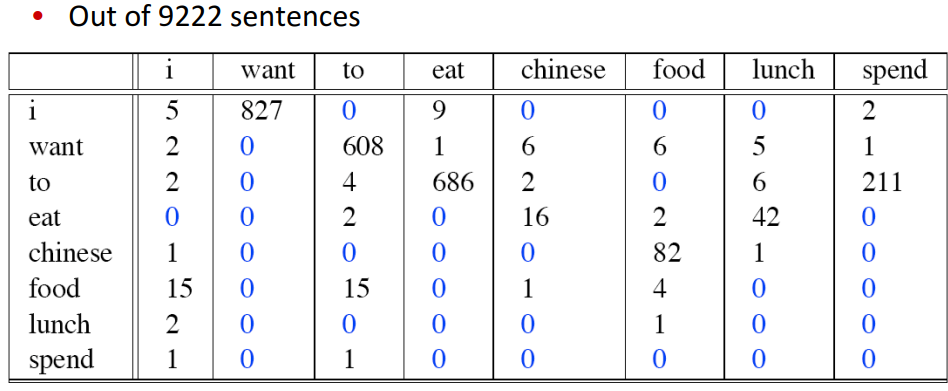

Above is an example of a bigram lookup table for words (not characters like in this example). This is for $n=2$ -- in other words, we map 1 context word to 1 output word. If we were computing trigrams, we would have 2 context words and 1 output word. 

Each row represents some context word, and each column represents the subsequent word. For example, this tells us that in the corpus used to create this table, the word "want" followed the word "i" 827 times. Obviously this table doesn't contain every word in English, but with a large enough corpus, you could see how this table could feasibly generate language in response to any context word.

Bigrams are probably the simplest "legitimate" language model, in the sense that they actually learn from data unlike SusGPT.

### Implementing a bigram model 

Below I'll show an example implementation for a **character-level** bigram language model trained on Shakespeare. Note that unlike above, we'll be using characters instead of words. This is for simplicity of understanding -- in practice, most language models are word-level or subword-level (we will get into what that means soon). You can download this dataset from [here](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt)

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


alphabet = 'abcdefghijklmnopqrstuvwxyz .'

counts = np.zeros((len(alphabet), len(alphabet))) # counts table. rows will be context, cols will be outputs
                  
with open('tinyshakespeare.txt', 'r') as f:
    txt = f.read()

txt_lower = txt.lower()


# helper dicts to go between indices and letters
txt2idx = {alphabet[i]:i for i in range(len(alphabet))}
idx2txt = {i:alphabet[i] for i in range(len(alphabet))} 

for idx in range(1, len(txt_lower)):
    ctx = txt_lower[idx-1]
    out = txt_lower[idx]
    
    if ctx not in alphabet or out not in alphabet: # skip non alphabet characters
        continue
    ctx_idx = txt2idx[ctx]
    out_idx = txt2idx[out]
    counts[ctx_idx][out_idx] += 1

In [116]:
# now, we transform these counts to distributions by dividing by the sum of rows
row_sums = counts.sum(axis=1, keepdims=True)

dist = counts / row_sums

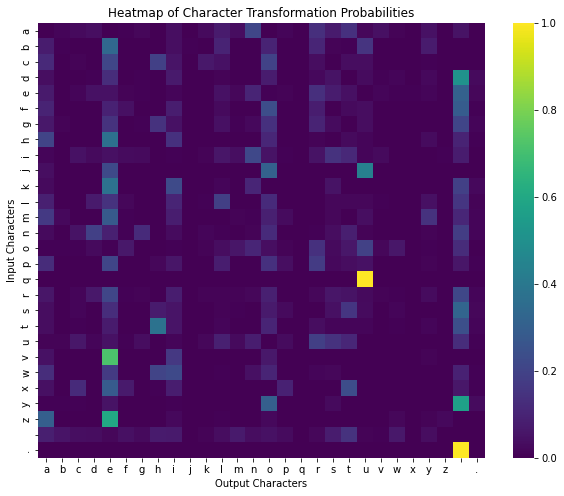

In [117]:
# Letters for annotation
letters = list('abcdefghijklmnopqrstuvwxyz .')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(dist, annot=False, fmt=".2f", cmap='viridis', xticklabels=letters, yticklabels=letters)

plt.xlabel('Output Characters')
plt.ylabel('Input Characters')
plt.title('Heatmap of Character Transformation Probabilities')
plt.show()

Woohoo! Our first language model is complete. Or maybe second, if you consider SusGPT to be a langauge model... anyways, let's see this model in action!

In [118]:
def sample_bigram(ctx):
    ctx_idx = txt2idx[ctx]
    next_tok_dist = dist[ctx_idx]
    out = np.random.choice(list(alphabet), p=next_tok_dist)
    return out

In [119]:
# sample 100 tokens

inp = "thou art"
out = ""
s = inp
for _ in range(100):
    res = sample_bigram(s[-1])
    s += res
    out += res
    
print(f'Input: {inp}')
print(f'Output: {out}')
print(f'Combined: {s}')

Input: thou art
Output: hedor dle inotery gh wiothanf cel handarininorirodsomard liuthtofou um fesa d ces fofise ng oivencli
Combined: thou arthedor dle inotery gh wiothanf cel handarininorirodsomard liuthtofou um fesa d ces fofise ng oivencli


### I would argue that the bigram model is not much better than SusGPT... so let's try trigrams

In [120]:
counts_tri = np.zeros((len(alphabet), len(alphabet), len(alphabet))) # counts table. rows will be context, cols will be outputs

for idx in range(2, len(txt_lower)):
    ctx1 = txt_lower[idx-2]
    ctx2 = txt_lower[idx-1]
    out = txt_lower[idx]
    
    if ctx1 not in alphabet or ctx2 not in alphabet or out not in alphabet: # skip non alphabet characters
        continue
    ctx_idx_1 = txt2idx[ctx1]
    ctx_idx_2 = txt2idx[ctx2]
    out_idx = txt2idx[out]
    counts_tri[ctx_idx_1][ctx_idx_2][out_idx] += 1

In [114]:
# now, we transform these counts to distributions by dividing by the sum of rows
# add small number to avoid div by 0
row_sums = counts_tri.sum(axis=-1, keepdims=True)
row_sums += 1e-7
dist_tri = counts_tri / row_sums

In [121]:
def sample_trigram(ctx1, ctx2):
    ctx_idx_1 = txt2idx[ctx1]
    ctx_idx_2 = txt2idx[ctx2]
    next_tok_dist = dist[ctx_idx_1][ctx_idx_2]
    out = np.random.choice(list(alphabet), p=next_tok_dist)
    return out

In [122]:
# sample 100 tokens

inp = "thou art"
out = ""
s = inp
for _ in range(100):
    res = sample_bigram(s[-1])
    s += res
    out += res
    
print(f'Input: {inp}')
print(f'Output: {out}')
print(f'Combined: {s}')

Input: thou art
Output: e kist. ct hemo h ppri s. adis lecithelit she o y ce beshe athiarin geal thy methesinofor relchenkne
Combined: thou arte kist. ct hemo h ppri s. adis lecithelit she o y ce beshe athiarin geal thy methesinofor relchenkne


Slightly better... but not great.

### Limitations of n-grams

As $n \rightarrow \infty$, you can imagine that the $n-gram$ model gets better and better. But this is computationally intractable. As $n$ increases by 1, we increase the size of our lookup table by a factor of $|A|$ for some alphabet $A$. In other words, the lookup table grows exponentially in $|A|$. If we have an alphabet of size 28 (a-z, space, and period), then each new context token we add multiples the size of our table by $28$, which is very bad. If we wanted to compute a table for 10-grams, we would need a table with $28^10 \approx 300 \text{trillion}$ entries. This is not very feasible, especially considering that most of these entries will correspond to nonsense contexts like "aaaaaaaaaa."

Another issue with these language models is that they don't take into account the dynamic nature of langauge. In the phrase 

$$\text{The quick brown fox jumps over the lazy dog}$$

the first "The" refers to the fox, whereas the second "the" refers to the dog. From the perspective of an trigram or bigram though, these inputs would be processed entirely the same, disregarding the context in the sequence. So without a sufficiently large context, n-gram models aren't able to pick up on the nuance of language.

## Closing thoughts

Hopefully this served as a good primer on language modeling. In the years since the n-gram was invented we've had plenty of other approaches to language modeling--for a while, [RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) were the best language models. But 2017 brought the Transformer, and I guess you guys all know the rest. So for the next meeting we'll start trying to grapple with self-attention, the key mechanism which powers the Transformer, and in the following weeks we'll get a bit more practical, talking about tokenization, pos encoding, encoder/decoder architectures + implementing some transformers ourselves!